In [44]:
import pandas as pd
import openpyxl
from itertools import chain
import re

structure_columns = ['Helix', 'Turn', 'Beta strand']

def extract_positions(cell, col_name):
    if pd.isna(cell):
        return []
    items = cell.split('; ')
    
    prefix_map = {
        'Helix': 'HELIX',
        'Turn': 'TURN',
        'Beta strand': 'STRAND'
    }
    
    prefix = prefix_map.get(col_name, '')
    return [item.replace(f'{prefix} ', '') for item in items if item.startswith(prefix)]

def extract_subsequences(sequence, positions):
    subsequences = []
    for start, end in positions:
        subseq = sequence[start-1:end]
        if len(subseq) == 0:
            print(f"Zero-length subsequence detected at positions {start} to {end}")
        subsequences.append(subseq)
    return subsequences

def extract_evidence(cell):
    eco_ids = []
    sources = []
    source_ids = []
    
    if not isinstance(cell, str):
        return pd.DataFrame({
            'ECO': eco_ids,
            'Source': sources,
            'ID': source_ids
        })
    
    pattern = r"ECO:([0-9]+)(?:\|(\w+):([\w\d]+))?"
    matches = re.findall(pattern, cell)
    
    for match in matches:
        eco_ids.append(match[0])
        sources.append(match[1] if match[1] else None)
        source_ids.append(match[2] if match[2] else None)
    
    return pd.DataFrame({
        'ECO': eco_ids,
        'Source': sources,
        'ID': source_ids
    })   

def extract_negative_subsequences(full_sequence, positive_subseq):
    negative_subseq = []
    last_end_position = 0
    
    for start, end in positive_subseq:
        if start > last_end_position + 1:
            neg_start, neg_end = last_end_position + 1, start - 1
            neg_seq = full_sequence[neg_start-1:neg_end]
            if len(neg_seq) == 0:
                print(f"Zero-length negative subsequence detected between {neg_start} and {neg_end}")
            negative_subseq.append((neg_start, neg_end, neg_seq))
        last_end_position = max(last_end_position, end)
    
    if last_end_position < len(full_sequence):
        neg_start, neg_end = last_end_position + 1, len(full_sequence)
        neg_seq = full_sequence[neg_start-1:neg_end]
        negative_subseq.append((neg_start, neg_end, neg_seq))
    
    return negative_subseq

def autoscale_excel(excel_path):
    book = openpyxl.load_workbook(excel_path)
    sheet = book.active
    
    for column in sheet.columns:
        max_length = max(len(str(cell.value)) for cell in column)
        adjusted_width = max_length + 2
        col_dim = openpyxl.utils.get_column_letter(column[0].column)
        sheet.column_dimensions[col_dim].width = adjusted_width
        
    book.save(excel_path)

def fetch_data(url, timeout=10):
    import requests
    from requests.exceptions import RequestException
    
    with requests.Session() as session:
        try:
            response = session.get(url, timeout=timeout)
            response.raise_for_status()
            if response.status_code == 200:
                return response.text
        except RequestException as e:
            print(f"An error occurred: {e}")
    return None

def read_url(url):
    from io import StringIO
    text_content = fetch_data(url)

    if text_content:
        return pd.read_csv(StringIO(text_content), sep='\t')
    else:
        print("Failed to retrieve or parse the data.")
        return None

In [45]:
file = 'human_reviewed.tsv'
url = 'https://rest.uniprot.org/uniprotkb/stream?fields=accession%2Cid%2Csequence%2Cft_helix%2Cft_turn%2Cft_strand&format=tsv&query=%28reviewed%3Atrue%29'

data = pd.read_csv(file, sep='\t')
# data = read_url(url)

data.dropna(subset=['Helix', 'Turn', 'Beta strand'], how='all', inplace=True)

In [46]:
positions_df = data[structure_columns].apply(lambda col: col.apply(lambda cell: extract_positions(cell, col.name)))
positions_df = positions_df.applymap(lambda pos_list: [(int(p.split('..')[0]), int(p.split('..')[1])) for p in pos_list])

In [47]:
subsequences_df = data.apply(lambda row: {col: extract_subsequences(row['Sequence'], positions_df.loc[row.name, col]) for col in structure_columns}, axis=1)

In [48]:
evidence_df = data[structure_columns].applymap(extract_evidence)

In [49]:
positive_data = []

for idx, row in data.iterrows():
    entry = row['Entry']
    for structure_type in structure_columns:
        pos_list = positions_df.loc[idx, structure_type]
        subseq_list = subsequences_df[idx][structure_type]
        evidence_list = evidence_df.loc[idx, structure_type]
        
        if len(pos_list) != len(subseq_list):
            print(f"Warning: Mismatch in number of positions and subsequences for Entry {entry}, Structure {structure_type}")
            continue

        for i, ((start_pos, end_pos), subseq) in enumerate(zip(pos_list, subseq_list)):
            excel_row = {
                'Entry': entry,
                'Sequence': subseq,
                'Start_position': start_pos,
                'End_position': end_pos,
                'Type': structure_type,
            }
            
            if isinstance(evidence_list, pd.DataFrame) and not evidence_list.empty and i < len(evidence_list):
                excel_row.update(evidence_list.iloc[i].to_dict())
            
            positive_data.append(excel_row)

positive_df = pd.DataFrame(positive_data)
print(positive_df['ECO'].unique())
print(positive_df['Source'].unique())
print(positive_df['ID'].unique())

['0007829']
['PDB']
['2DIS' '4YO2' '7PVN' ... '2L2O' '2LON' '2DAW']


In [50]:
positive_df.dropna(subset=['Source', 'ID'], how='all', inplace=True)
print(positive_df['ECO'].unique())
print(positive_df['Source'].unique())
print(positive_df['ID'].unique())
positive_df

['0007829']
['PDB']
['2DIS' '4YO2' '7PVN' ... '2L2O' '2LON' '2DAW']


,Entry,Sequence,Start_position,End_position,Type,ECO,Source,ID
0,A0AV96,REEILEEIAKV,164,174,Helix,0007829,PDB,2DIS
1,A0AV96,HRAAAMAR,204,211,Helix,0007829,PDB,2DIS
2,A0AV96,DKMKN,189,193,Turn,0007829,PDB,2DIS
3,A0AV96,RKLMP,212,216,Turn,0007829,PDB,2DIS
4,A0AV96,VDE,237,239,Turn,0007829,PDB,2DIS
...,...,...,...,...,...,...,...,...
184797,Q9UIY3,EVKLE,28,32,Beta strand,0007829,PDB,2DAW
184798,Q9UIY3,IEFVITLQI,55,63,Beta strand,0007829,PDB,2DAW
184799,Q9UIY3,VKIDLQVTM,68,76,Beta strand,0007829,PDB,2DAW
184800,Q9UIY3,QLFGR,86,90,Beta strand,0007829,PDB,2DAW


In [9]:
excel_path = f"./{file.replace('.tsv', '')}.xlsx" if file else f'result.xlsx'
positive_df.to_excel(excel_path, index=False)
autoscale_excel(positive_df)

In [36]:
csv_path = f"./{file.replace('.tsv', '')}.csv" if file else f'result.csv'
positive_df.to_csv(csv_path, index=False)

In [51]:
positive_subseq_dict = {entry: df[['Start_position', 'End_position']].sort_values(by='Start_position').values.tolist()
                          for entry, df in positive_df.groupby('Entry')}
negative_data = []

for entry, full_sequence in data[['Entry', 'Sequence']].values:
    positive_subseq = positive_subseq_dict.get(entry, [])
    negative_subseq = extract_negative_subsequences(full_sequence, positive_subseq)
    
    negative_data += [{'Entry': entry, 'Sequence': seq, 'Start_position': start, 'End_position': end} 
                                for start, end, seq in negative_subseq]

negative_df = pd.DataFrame(negative_data)
negative_df

,Entry,Sequence,Start_position,End_position
0,A0AV96,MTAEDSTAAMSSDSAAGSSAKVPEGVAGAPNEAALLALMERTGYSM...,1,149
1,A0AV96,GIPKMKK,157,163
2,A0AV96,TEG,175,177
3,A0AV96,VY,183,184
4,A0AV96,A,188,188
...,...,...,...,...
159147,Q9UIY3,S,91,91
159148,Q9UIY3,D,95,95
159149,Q9UIY3,GTFDPGELC,111,119
159150,Q9UIY3,NS,130,131


In [52]:
total_structure_length = (positive_df['End_position'] - positive_df['Start_position'] + 1).groupby(positive_df['Entry']).sum()
total_protein_length = data[data['Entry'].isin(positive_df['Entry'])].groupby('Entry')['Sequence'].first().apply(len)
structure_percentage = (round(total_structure_length / total_protein_length * 100)).reset_index(name='Structure_Percentage')

negative_df = pd.merge(negative_df, structure_percentage, on='Entry', how='left') if 'Structure_Percentage' not in negative_df.columns else negative_df
negative_df

,Entry,Sequence,Start_position,End_position,Structure_Percentage
0,A0AV96,MTAEDSTAAMSSDSAAGSSAKVPEGVAGAPNEAALLALMERTGYSM...,1,149,10.0
1,A0AV96,GIPKMKK,157,163,10.0
2,A0AV96,TEG,175,177,10.0
3,A0AV96,VY,183,184,10.0
4,A0AV96,A,188,188,10.0
...,...,...,...,...,...
159147,Q9UIY3,S,91,91,32.0
159148,Q9UIY3,D,95,95,32.0
159149,Q9UIY3,GTFDPGELC,111,119,32.0
159150,Q9UIY3,NS,130,131,32.0


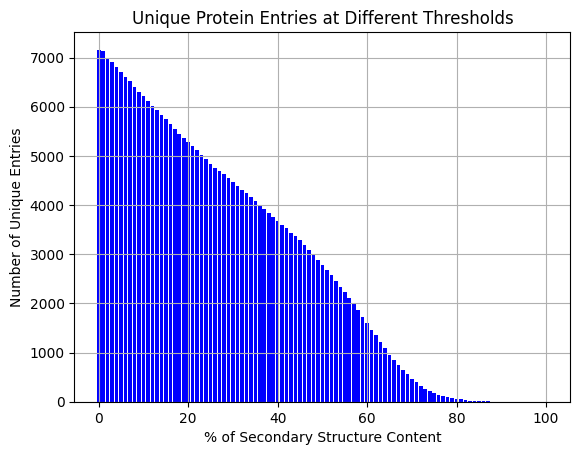

In [35]:
import matplotlib.pyplot as plt

threshold_dfs = {}

thresholds = range(0, 101)
unique_entries = []

for threshold in thresholds:
    threshold_dfs[threshold] = negative_df[negative_df['Structure_Percentage'] >= threshold]
    unique_entries.append(threshold_dfs[threshold]['Entry'].nunique())

thresholds = list(thresholds)

plt.bar(thresholds, unique_entries, color='blue')
plt.xlabel('% of Secondary Structure Content')
plt.ylabel('Number of Unique Entries')
plt.title('Unique Protein Entries at Different Thresholds')
plt.grid(True)
plt.show()

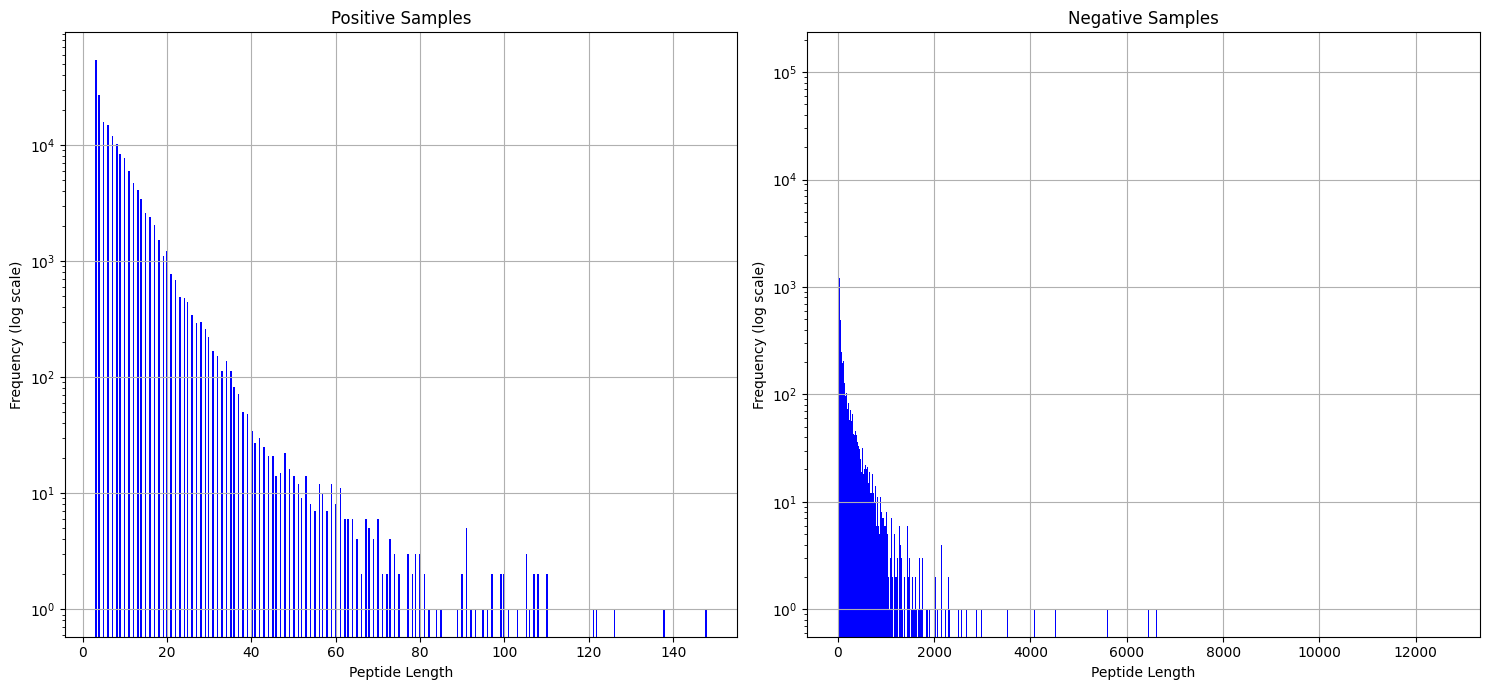

In [79]:
def calculate_bin_width(lengths):
    R = lengths.max() - lengths.min()
    n = len(lengths)
    std = lengths.std()
    return int((R * (n ** (1/3))) / (3.49 * std))

positive_lengths = positive_df['Sequence'].apply(len)
negative_lengths = negative_df['Sequence'].apply(len)

bin_positive = calculate_bin_width(positive_lengths)
bin_negative = calculate_bin_width(negative_lengths)

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.hist(positive_lengths, bins=bin_positive, color='blue', label='Positive', log=True)
plt.xlabel('Peptide Length')
plt.ylabel('Frequency (log scale)')
plt.title('Positive Samples')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(negative_lengths, bins=bin_negative, color='blue', label='Positive', log=True)
plt.xlabel('Peptide Length')
plt.ylabel('Frequency (log scale)')
plt.title('Negative Samples')
plt.grid(True)

plt.tight_layout()
plt.show()

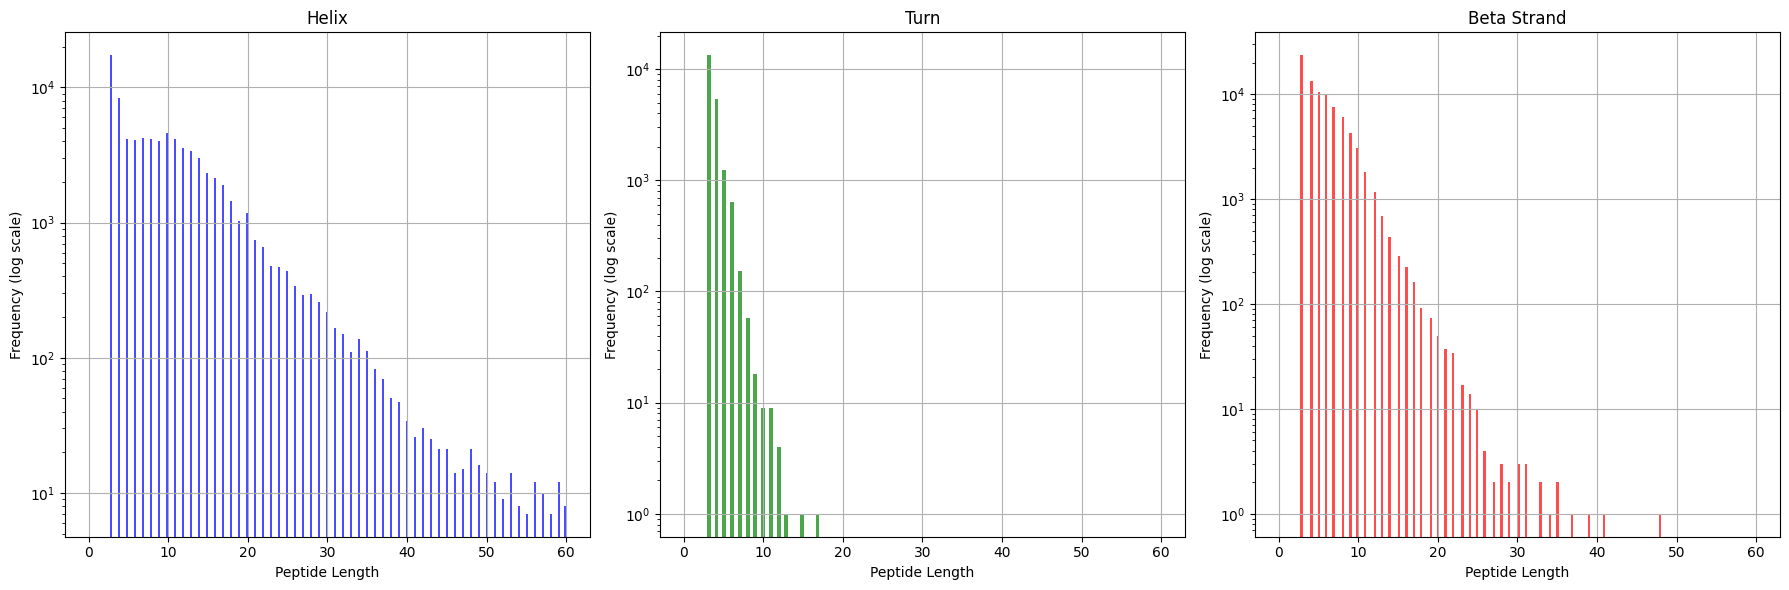

In [85]:
helix_lengths = positive_df[positive_df['Type'] == 'Helix']['Sequence'].apply(len)
turn_lengths = positive_df[positive_df['Type'] == 'Turn']['Sequence'].apply(len)
beta_strand_lengths = positive_df[positive_df['Type'] == 'Beta strand']['Sequence'].apply(len)

bin_width_helix = calculate_bin_width(helix_lengths)
bin_width_turn = calculate_bin_width(turn_lengths)
bin_width_beta_strand = calculate_bin_width(beta_strand_lengths)

plt.figure(figsize=(18, 6))

# Histogram for Helix
plt.subplot(1, 3, 1)
plt.hist(helix_lengths, bins=bin_width_helix, range=(0, 60), color='blue', alpha=0.7, log=True)
plt.xlabel('Peptide Length')
plt.ylabel('Frequency (log scale)')
plt.title('Helix')
plt.grid(True)

# Histogram for Turn
plt.subplot(1, 3, 2)
plt.hist(turn_lengths, bins=bin_width_turn, range=(0, 60), color='green', alpha=0.7, log=True)
plt.xlabel('Peptide Length')
plt.ylabel('Frequency (log scale)')
plt.title('Turn')
plt.grid(True)

# Histogram for Beta Strand
plt.subplot(1, 3, 3)
plt.hist(beta_strand_lengths, bins=bin_width_beta_strand, range=(0, 60), color='red', alpha=0.7, log=True)
plt.xlabel('Peptide Length')
plt.ylabel('Frequency (log scale)')
plt.title('Beta Strand')
plt.grid(True)

plt.tight_layout()
plt.show()